In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

import cv2
from PIL import Image


In [21]:
# Caminho para a pasta onde estão as subpastas 'adenocarcinoma', 'benign', 'squamous_cell_carcinoma'
base_path = "C:\\Users\\dcris\\Desktop\\ADNE\\archive"

# Verifica as classes disponíveis
classes = os.listdir(base_path)
print(f"Classes encontradas: {classes}")

# Conta quantas imagens há por classe
for classe in classes:
    class_path = os.path.join(base_path, classe)
    num_images = len(os.listdir(class_path))
    print(f"{classe}: {num_images} imagens")


Classes encontradas: ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
adenocarcinoma: 4500 imagens
benign: 4500 imagens
squamous_cell_carcinoma: 4500 imagens


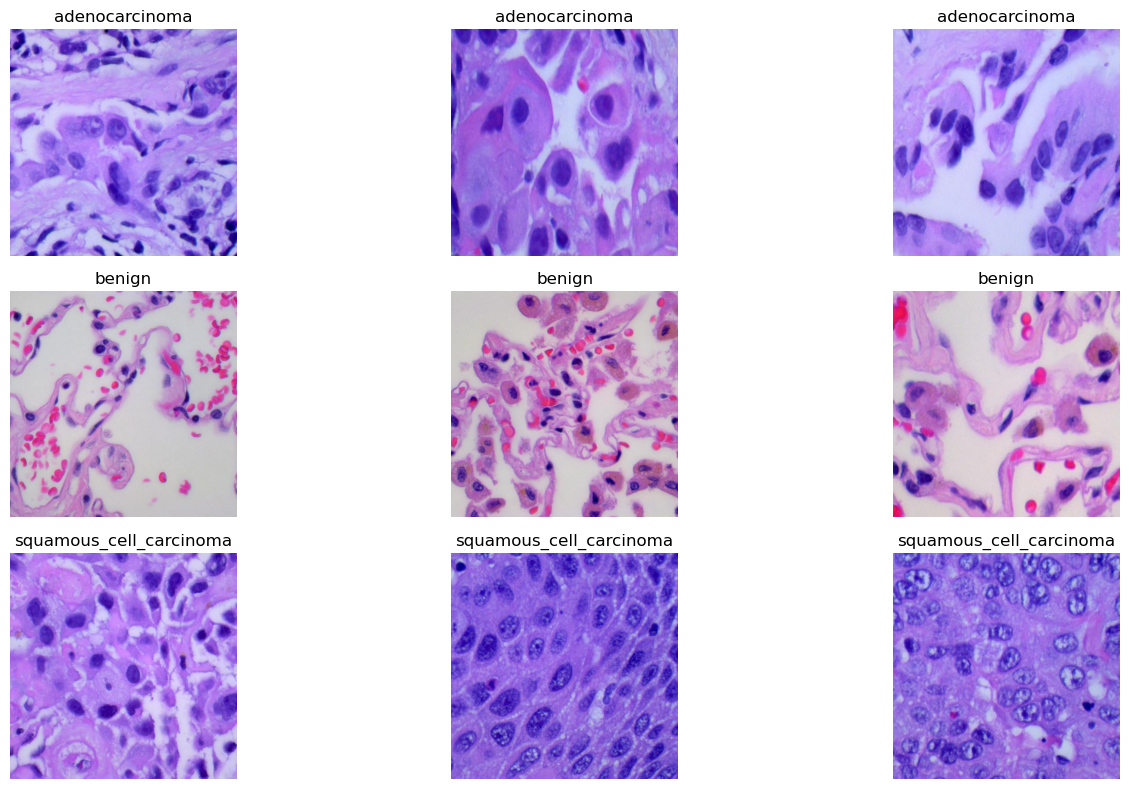

In [22]:
def show_sample_images(base_path, classes, samples_per_class=3):
    plt.figure(figsize=(15, 8))
    for i, classe in enumerate(classes):
        class_path = os.path.join(base_path, classe)
        images = os.listdir(class_path)
        for j in range(samples_per_class):
            img_path = os.path.join(class_path, random.choice(images))
            img = Image.open(img_path)
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(classe)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(base_path, classes)


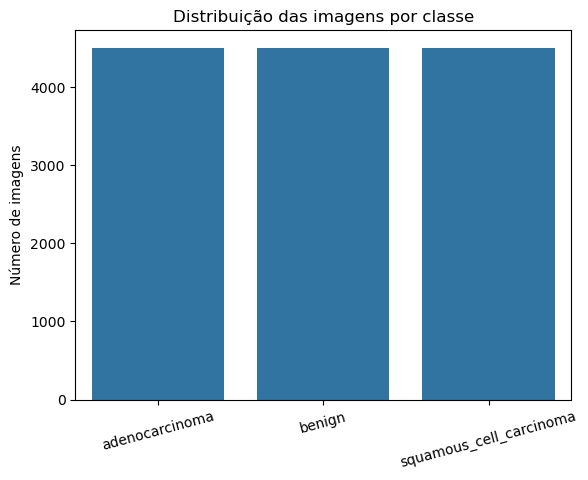

In [23]:
class_counts = {classe: len(os.listdir(os.path.join(base_path, classe))) for classe in classes}
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Distribuição das imagens por classe")
plt.ylabel("Número de imagens")
plt.xticks(rotation=15)
plt.show()


In [24]:
#redimensiona as imagens

img_size = (64, 64)
#o modelo vai processar 32 imagens de cada vez durante o treino.
batch_size = 32

#funcao muito util
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)# Normaliza os valores dos pixels (que vão de 0 a 255) para o intervalo [0, 1]; 

#gerador de treino
train_generator = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#gerador de validaçao

val_generator = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


# Novo gerador para o conjunto de teste (sem split)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,                    # Caminho para a nova pasta de teste 
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False                 # Mantém a ordem das imagens
)

Found 12150 images belonging to 3 classes.
Found 1350 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


MLP

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# MLP Tunado
mlp_tuned = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

mlp_tuned.compile(
    optimizer=Adam(learning_rate=0.0005),  # mais lento mas mais preciso
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treino com mais épocas
history_tuned = mlp_tuned.fit(
    train_generator,
    validation_data=val_generator,
    epochs=6,
    verbose=1
)


c:\Users\dcris\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\dcris\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
380/380 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.5750 - loss: 1.0009 - val_accuracy: 0.6993 - val_loss: 0.5318
Epoch 2/6
380/380 ━━━━━━━━━━━━━━━━━━━━ 329s 865ms/step - accuracy: 0.6871 - loss: 0.5634 - val_accuracy: 0.7585 - val_loss: 0.4977
Epoch 3/6
380/380 ━━━━━━━━━━━━━━━━━━━━ 310s 816ms/step - accuracy: 0.6973 - loss: 0.5600 - val_accuracy: 0.6652 - val_loss: 0.5681
Epoch 4/6
380/380 ━━━━━━━━━━━━━━━━━━━━ 598s 2s/step - accuracy: 0.7110 - loss: 0.5575 - val_accuracy: 0.7578 - val_loss: 0.4905
Epoch 5/6
380/380 ━━━━━━━━━━━━━━━━━━━━ 1480s 4s/step - accuracy: 0.6512 - loss: 0.6517 - val_accuracy: 0.7563 - val_loss: 0.5399
Epoch 6/6
380/380 ━━━━━━━━━━━━━━━━━━━━ 2231s 6s/step - accuracy: 0.6742 - loss: 0.6162 - val_accuracy: 0.7622 - val_loss: 0.5068


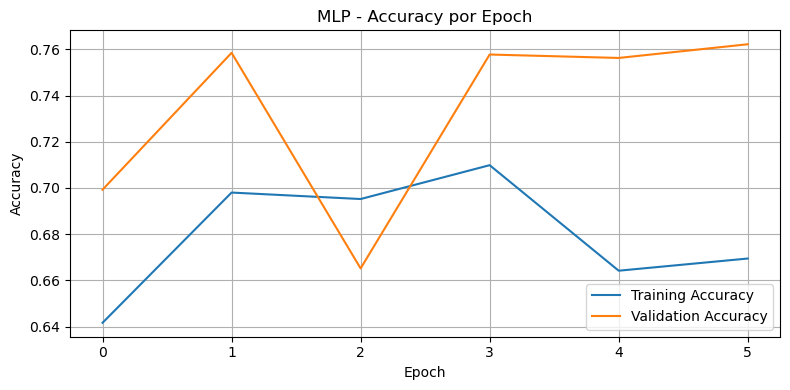

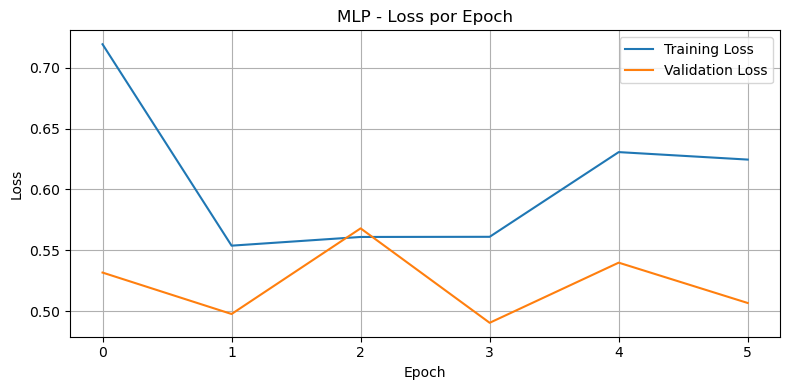

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step
📋 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.60      0.85      0.70       450
                 benign       0.99      0.93      0.96       450
squamous_cell_carcinoma       0.78      0.51      0.62       450

               accuracy                           0.76      1350
              macro avg       0.79      0.76      0.76      1350
           weighted avg       0.79      0.76      0.76      1350



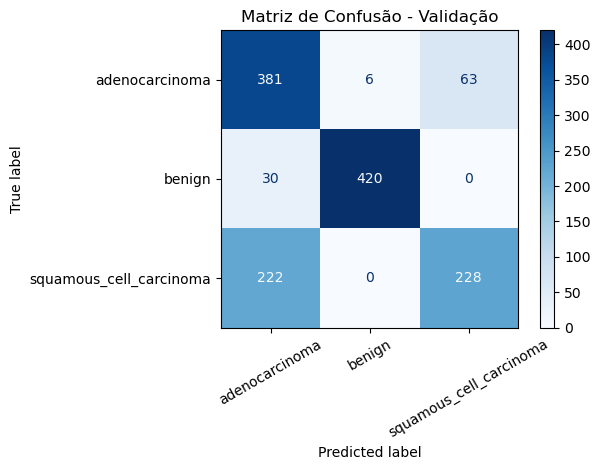

In [30]:
import matplotlib.pyplot as plt

# Gráfico de accuracy
plt.figure(figsize=(8, 4))
plt.plot(history_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Validation Accuracy')

plt.title('MLP - Accuracy por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico de loss
plt.figure(figsize=(8, 4))
plt.plot(history_tuned.history['loss'], label='Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')

plt.title('MLP - Loss por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Previsões no conjunto de validação
val_generator.reset()  # Garante a ordem correta
pred_probs = mlp_tuned.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Relatório com precision, recall e f1-score
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=30)
plt.title("Matriz de Confusão - Validação")
plt.tight_layout()
plt.show()


Found 1500 images belonging to 3 classes.
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8545 - loss: 0.5131
Test Loss: 0.4767
Test Accuracy: 0.7880
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step
📋 Classification Report - Test Set:
                         precision    recall  f1-score   support

         adenocarcinoma       0.63      0.86      0.73       500
                 benign       0.99      0.96      0.98       500
squamous_cell_carcinoma       0.80      0.55      0.65       500

               accuracy                           0.79      1500
              macro avg       0.81      0.79      0.79      1500
           weighted avg       0.81      0.79      0.79      1500



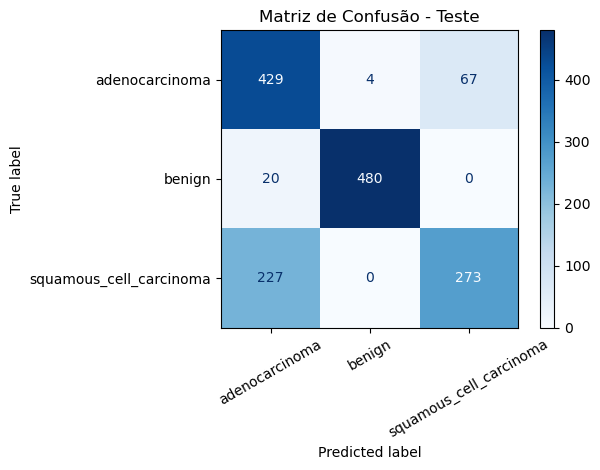

In [34]:
test_path  = "C:\\Users\\dcris\\Desktop\\ADNE\\imagens teste"

## avaliaçao test set
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
results = mlp_tuned.evaluate(test_generator)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

##visualizacao
test_generator.reset()

# Obter previsões do modelo
test_probs = mlp_tuned.predict(test_generator)
y_test_pred = np.argmax(test_probs, axis=1)
y_test_true = test_generator.classes
class_labels_test = list(test_generator.class_indices.keys())

# Relatório detalhado
print("📋 Classification Report - Test Set:")
print(classification_report(y_test_true, y_test_pred, target_names=class_labels_test))

# Matriz de confusão
cm_test = confusion_matrix(y_test_true, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels_test)
disp_test.plot(cmap='Blues', xticks_rotation=30)
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()


CNN

In [6]:
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\dcris\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,056,259 (240.54 MB)

 Trainable params: 63,056,259 (240.54 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    #verbose=1
)

c:\Users\dcris\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
380/380 ━━━━━━━━━━━━━━━━━━━━ 80649s 213s/step - accuracy: 0.7066 - loss: 2.2120 - val_accuracy: 0.8459 - val_loss: 0.3593
Epoch 2/2
380/380 ━━━━━━━━━━━━━━━━━━━━ 1368s 4s/step - accuracy: 0.8925 - loss: 0.2646 - val_accuracy: 0.9119 - val_loss: 0.2196


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step
📊 Avaliação no conjunto de VALIDAÇÃO
                         precision    recall  f1-score   support

         adenocarcinoma       0.64      0.98      0.78       450
                 benign       0.98      0.99      0.99       450
squamous_cell_carcinoma       0.99      0.46      0.63       450

               accuracy                           0.81      1350
              macro avg       0.87      0.81      0.80      1350
           weighted avg       0.87      0.81      0.80      1350



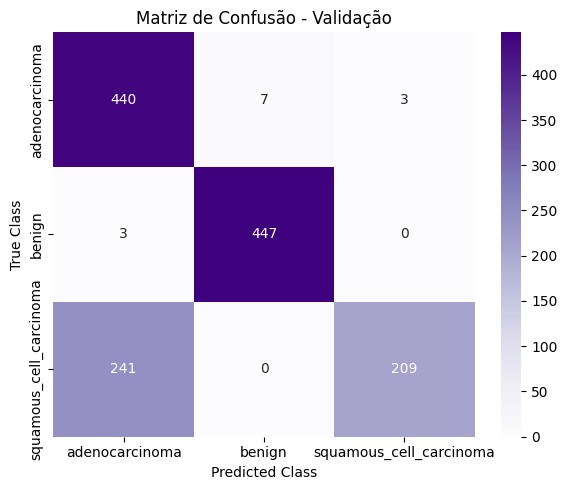

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obter previsões
val_preds_probs = model.predict(val_generator)
val_preds = np.argmax(val_preds_probs, axis=1)
val_true = val_generator.classes

# Nomes das classes
class_names = list(val_generator.class_indices.keys())

# Relatório
print("📊 Avaliação no conjunto de VALIDAÇÃO")
print(classification_report(val_true, val_preds, target_names=class_names))

# Matriz de confusão
cm_val = confusion_matrix(val_true, val_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão - Validação")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.9489 - loss: 0.1348

✅ Acurácia no conjunto de TESTE: 82.27%
📉 Loss no conjunto de TESTE: 0.4630
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step

📊 Avaliação detalhada no conjunto de TESTE
                         precision    recall  f1-score   support

         adenocarcinoma       0.66      0.99      0.79       500
                 benign       0.99      0.99      0.99       500
squamous_cell_carcinoma       0.98      0.49      0.66       500

               accuracy                           0.82      1500
              macro avg       0.88      0.82      0.81      1500
           weighted avg       0.88      0.82      0.81      1500



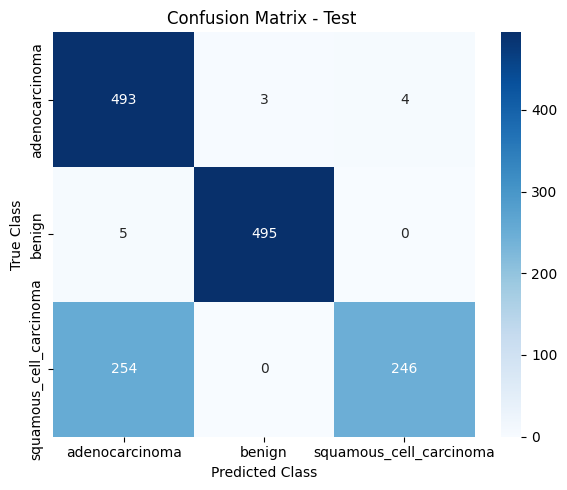

In [17]:
# Avaliação direta com o model.evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Acurácia no conjunto de TESTE: {test_acc:.2%}")
print(f"📉 Loss no conjunto de TESTE: {test_loss:.4f}")

# Previsões detalhadas
test_preds_probs = model.predict(test_generator)
test_preds = np.argmax(test_preds_probs, axis=1)
test_true = test_generator.classes

# Nomes das classes
class_names = list(test_generator.class_indices.keys())

# Relatório
print("\n📊 Avaliação detalhada no conjunto de TESTE")
print(classification_report(test_true, test_preds, target_names=class_names))

# Matriz de confusão
cm_test = confusion_matrix(test_true, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Test ")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()


In [ ]:

# Hiperparâmetros a testar
filter_options = [32, 64]
dense_options = [64, 128]
epoch_options = 2
optimizer_options = ['adam']

# Guardar resultados
results = []

# Loop de tuning
for f in filter_options:
    for d in dense_options:
        for e in epoch_options:
            for opt in optimizer_options:
                print(f"\n🔧 Training with filters={f}, dense={d}, epochs={e}, optimizer={opt}")

                # Modelo
                model = models.Sequential([
                    layers.Conv2D(f, (3,3), activation='relu', input_shape=(256, 256, 3)),
                    layers.MaxPooling2D((2,2)),
                    layers.Conv2D(f*2, (3,3), activation='relu'),
                    layers.MaxPooling2D((2,2)),
                    layers.Flatten(),
                    layers.Dense(d, activation='relu'),
                    layers.Dense(3, activation='softmax')
                ])

                model.compile(optimizer=opt,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

                history = model.fit(
                    train_generator,
                    epochs=e,
                    validation_data=val_generator,
                    verbose=0
                )

                # Previsões e avaliação
                val_preds_probs = model.predict(val_generator, verbose=0)
                val_preds = np.argmax(val_preds_probs, axis=1)
                val_true = val_generator.classes

                acc = np.mean(val_preds == val_true)

                results.append({
                    'Filters': f,
                    'Dense Units': d,
                    'Epochs': e,
                    'Optimizer': opt,
                    'Val Accuracy': acc
                })

# Resultados finais
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Val Accuracy', ascending=False).reset_index(drop=True)

import seaborn as sns
import matplotlib.pyplot as plt
import ace_tools as tools; import pandas as pd
tools.display_dataframe_to_user(name="Hyperparameter Tuning Results", dataframe=results_df)

# Mostrar top-1
top_result = results_df.iloc[0]
print("\n🏆 Best combination:")
print(top_result)



🔧 Training with filters=32, dense=64, epochs=2, optimizer=adam

🔧 Training with filters=32, dense=64, epochs=3, optimizer=adam


KeyboardInterrupt: 